In [1]:
# %pip install torch torchvision

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for reproducible results

Random Seed:  999


In [9]:
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

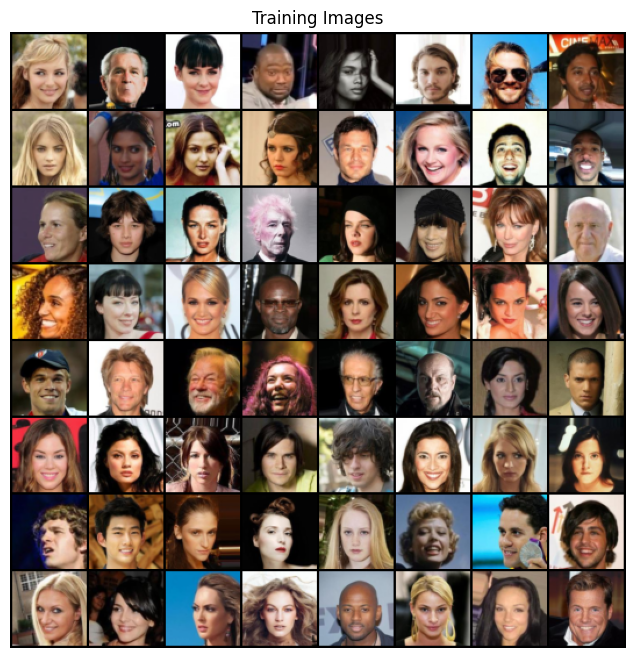

In [11]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
# Create the dataloader

from src.mod.datasets import CelebA

transform = transforms.Compose([
  transforms.RandomResizedCrop(64),
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  transforms.RandomRotation(degrees=(0, 5)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CelebA(
  dataset_path='../resources/datasets/celeba',
  image_directory='images',
  annotations_directory='annotations',
  max_image_count=5000,
  image_transform=transform
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [36]:

from src.mod.models import Generator, Discriminator

In [46]:
generator = Generator(100, 64, 3, with_init=True).to(device)
discriminator = Discriminator(3, 64, with_init=True).to(device)


In [47]:
from src.mod.datasets.utils import create_latent_vectors
criterion = nn.BCELoss()

fixed_noise = create_latent_vectors(64, 100, device)

real_label = 1.
fake_label = 0.

descriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

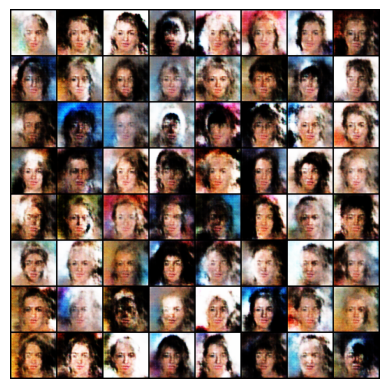


Batches:  25%|██▌       | 10/40 [00:13<00:38,  1.29s/it]

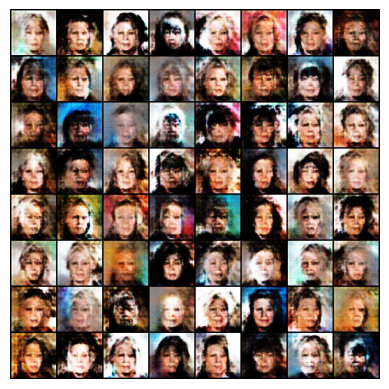


Batches:  50%|█████     | 20/40 [00:27<00:27,  1.36s/it]

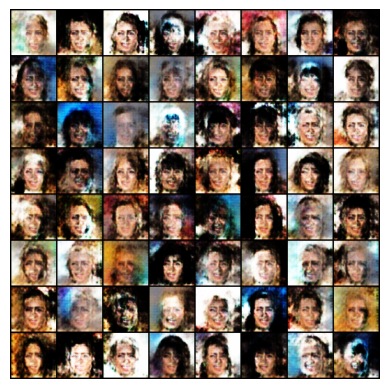


Batches:  75%|███████▌  | 30/40 [00:40<00:13,  1.31s/it]

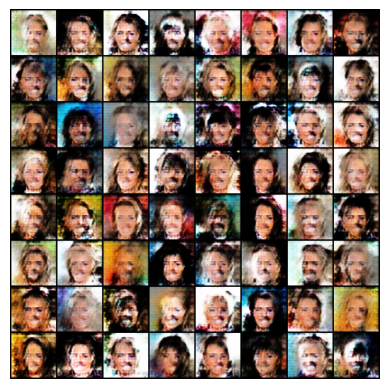


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

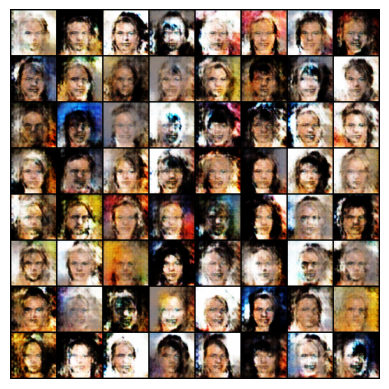


Batches:  25%|██▌       | 10/40 [00:13<00:38,  1.28s/it]

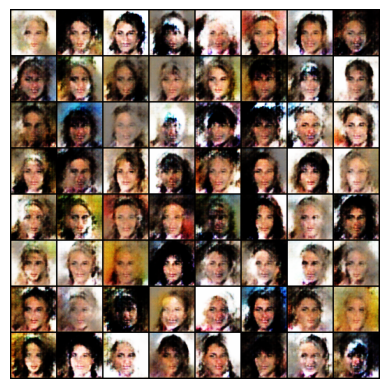


Batches:  50%|█████     | 20/40 [00:30<00:29,  1.45s/it]

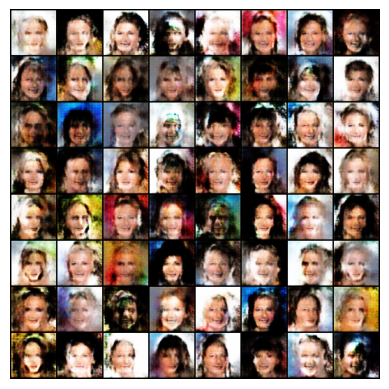


Batches:  75%|███████▌  | 30/40 [00:43<00:13,  1.38s/it]

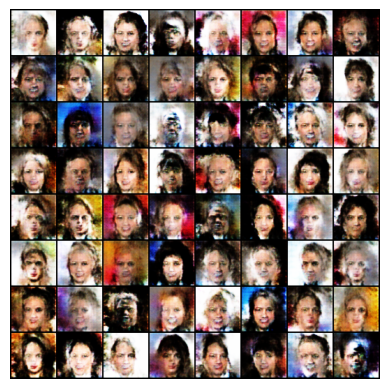


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

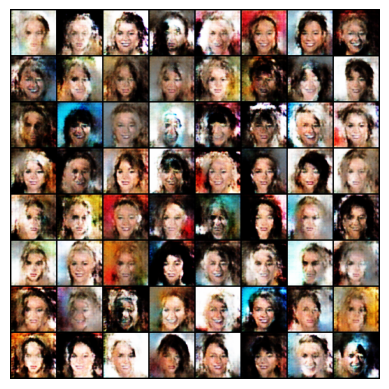


Batches:  25%|██▌       | 10/40 [00:14<00:40,  1.34s/it]

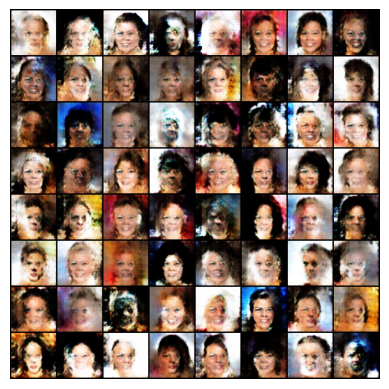


Batches:  50%|█████     | 20/40 [00:27<00:26,  1.32s/it]

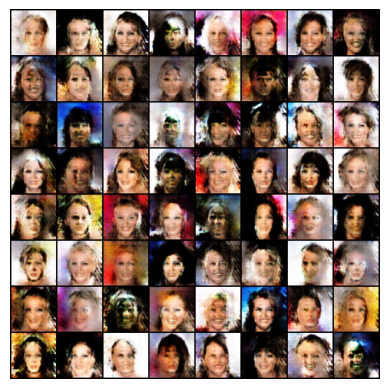


Batches:  75%|███████▌  | 30/40 [00:42<00:13,  1.37s/it]

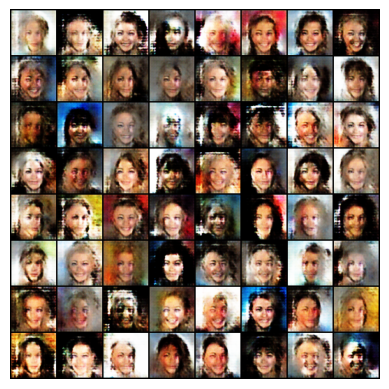


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

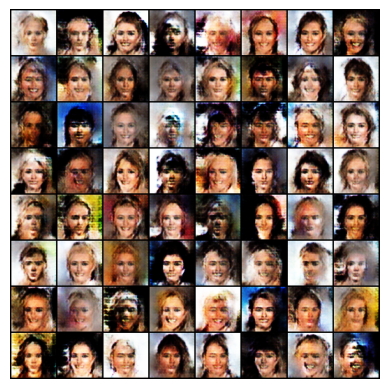


Batches:  25%|██▌       | 10/40 [00:15<00:41,  1.37s/it]

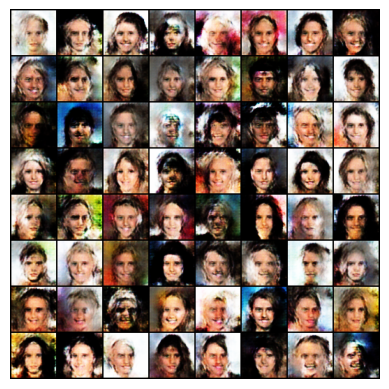


Batches:  50%|█████     | 20/40 [00:30<00:27,  1.39s/it]

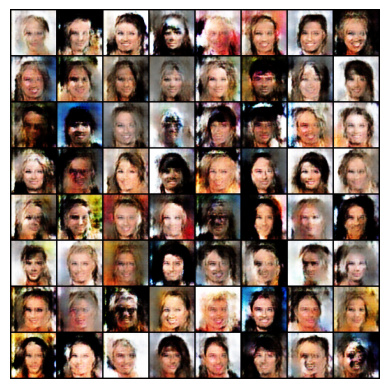


Batches:  75%|███████▌  | 30/40 [00:41<00:12,  1.26s/it]

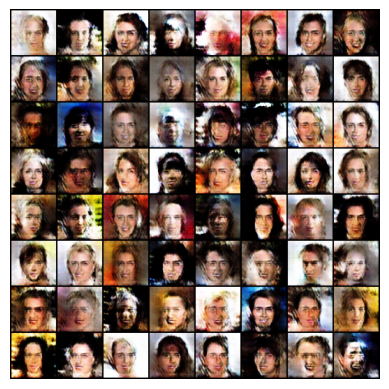


Epochs: 100%|██████████| 20/20 [17:57<00:00, 53.87s/it]


In [52]:
from demo.utils.utils import show_images
from tqdm import tqdm

num_epochs = 20
iters = 0
print("Starting Training Loop...")
for epoch in tqdm(range(num_epochs), desc="Epochs", total=num_epochs):
  for i, data in tqdm(enumerate(dataloader, 0), desc="Batches", total=len(dataloader)):
    discriminator.zero_grad()
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output = discriminator(real_cpu).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    noise = create_latent_vectors(b_size, 100, device)
    fake = generator(noise)
    label.fill_(fake_label)
    
    output = discriminator(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    descriminator_optimizer.step()

    generator.zero_grad()
    label.fill_(real_label)
    output = discriminator(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    generator_optimizer.step()


    if (iters % 50 == 0):
      with torch.no_grad(): fake = generator(fixed_noise).detach().cpu()
      show_images(fake)

    iters += 1

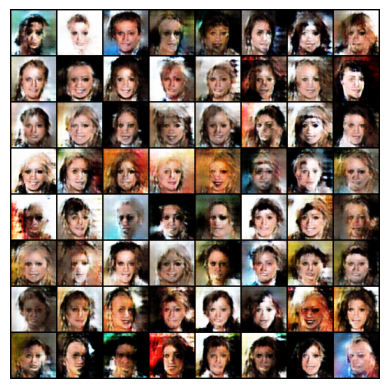

In [56]:
generated = generator(create_latent_vectors(64, 100, device)).detach().cpu()

show_images(generated)

In [57]:
torch.save(generator.state_dict(), 'generator-2.pt')
torch.save(discriminator.state_dict(), 'discriminator-2.pt')